In [1]:
import struct
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [6]:
# Set the dimensions of the volume
width = 181
height = 217
depth = 181

# Open the input file in binary mode
with open("BrainWeb/t1_icbm_normal_1mm_pn9_rf40.rawb", "rb") as file:
    # Loop through each slice in the volume
    for z in range(depth):
        # Create a new PGM file for the slice
        with open(f'Extracted_files//pgm//t1_icbm_normal_1mm_pn9_rf40//slice_{z}.pgm', "w+") as pgm_file:
            # Write the PGM file header
            pgm_file.write("P2\n")
            pgm_file.write("#\n")
            pgm_file.write(f"{width} {height}\n")
            pgm_file.write("255\n")

            # Loop through each row in the slice
            for y in range(height):
                # Read a row of data from the input file
                row_data = file.read(width)  # Each value is 1 byte
                # Unpack the row data into a list of integers
                values = struct.unpack(f"{width}B", row_data)
                
                scaled_values = [int(v) for v in values]

                # Convert each scaled value to decimal and write it to the PGM file
                pgm_file.write(" ".join([str(v) for v in scaled_values]) + "\n")

In [7]:
# Set the input and output directories
input_dir = "Extracted_files/pgm/t1_icbm_normal_1mm_pn9_rf40"
output_dir = "Extracted_files/jpg/t1_icbm_normal_1mm_pn9_rf40"

# Loop through all of the PGM files in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".pgm"):
        # Open the PGM file
        with Image.open(os.path.join(input_dir, file)) as img:
            # Convert the PGM file to a JPEG file
            img.save(os.path.join(output_dir, os.path.splitext(file)[0] + ".jpg"), "JPEG")


In [8]:

def dfs(x, y, data, skull_mask):
    nxt = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    for (dx, dy) in nxt:
        if 0 <= dx < data.shape[0] and 0 <= dy < data.shape[1] and data[dx, dy] > 0 and not vis[dx][dy]:
            vis[dx][dy] = True
            skull_mask[dx, dy] = True
            dfs(dx, dy, data, skull_mask)

# Input and output folders
input_folder =  'volumes2\\t1_icbm_normal_1mm_pn9_rf40'
output_folder = 'skullstriped2\\t1_icbm_normal_1mm_pn9_rf40\\jpg'

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            # Read the image
            filepath = os.path.join(input_folder, filename)
            #print("Processing:", filepath)  # Add debug output
            data = io.imread(filepath, as_gray=True).astype(int)


            vis = np.zeros_like(data, dtype=bool)
            skull_mask = np.zeros_like(data, dtype=bool)

            max_count = 0

            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    if data[i, j] > 42 and not vis[i][j]:
                        temp_skull_mask = np.zeros_like(data, dtype=bool)
                        stck = [(i, j)]
                        current_count = 0
                        while stck:
                            x, y = stck.pop()
                            temp_skull_mask[x, y] = True
                            current_count += 1
                            nxt = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
                            for (dx, dy) in nxt:
                                if 0 <= dx < data.shape[0] and 0 <= dy < data.shape[1] and data[dx, dy] > 42 and not vis[dx][dy]:
                                    vis[dx][dy] = True
                                    stck.append((dx, dy))
                        if current_count > max_count:
                            max_count = current_count
                            skull_mask = temp_skull_mask

            # Apply skull mask to the original image to obtain the skull region
            skull_image = np.where(skull_mask, data, 0)

            # Save the skull-stripped image to the output folder
            output_filepath = os.path.join(output_folder, filename)
            io.imsave(output_filepath, skull_image.astype(np.uint8))

           # print(f"Processed: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Processing complete.")


Processing complete.


In [9]:
def jpg_to_p2_pgm(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            # Read the image
            input_file = os.path.join(input_folder, filename)
            img = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)

            # Write the image in P2 PGM format
            output_file = os.path.join(output_folder, os.path.splitext(filename)[0] + ".pgm")
            with open(output_file, 'w') as f:
                f.write("P2\n")
                f.write("# P2 PGM file\n")
                f.write(f"{img.shape[1]} {img.shape[0]}\n")  # Width and height
                f.write("255\n")  # Maximum gray value
                for row in img:
                    for pixel in row:
                        f.write(f"{pixel} ")
                    f.write("\n")

# Example usage:
input_folder = 'skullstriped2\\t1_icbm_normal_1mm_pn9_rf40\\jpg'
output_folder = 'skullstriped2\\t1_icbm_normal_1mm_pn9_rf40\\pgm'
jpg_to_p2_pgm(input_folder, output_folder)

In [10]:

# Function to split dataset into train and test sets
def split_dataset(image_dir, gt_dir, test_size=0.2, random_state=42):
    # Get list of image filenames
    image_filenames = sorted(os.listdir(image_dir))
    
    # Get corresponding list of ground truth filenames
    gt_filenames = sorted(os.listdir(gt_dir))
    
    # Split filenames into train and test sets
    image_filenames_train, image_filenames_test, gt_filenames_train, gt_filenames_test = train_test_split(
        image_filenames, gt_filenames, test_size=test_size, random_state=random_state)
    
    return (image_filenames_train, gt_filenames_train), (image_filenames_test, gt_filenames_test)

# Example usage:
image_dir = r"Skullstriped2\\t1_icbm_normal_1mm_pn0_rf0\\pgm"
gt_dir = r"volumes2\\phantom_1.0mm_normal_crisp"
test_size = 0.2  # 40% of the data will be used for testing
random_state = 42  # Random seed for reproducibility

# Split dataset into training and testing sets
(train_files, train_gt_files), (test_files, test_gt_files) = split_dataset(image_dir, gt_dir, test_size, random_state)

train_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train'
test_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test'
train_gt_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train_masks'
test_gt_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test_masks'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_gt_dir, exist_ok=True)
os.makedirs(test_gt_dir, exist_ok=True)

# Copy train files to train directory
for file_name, gt_file_name in zip(train_files, train_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(train_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(train_gt_dir, gt_file_name))

# Copy test files to test directory
for file_name, gt_file_name in zip(test_files, test_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(test_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(test_gt_dir, gt_file_name))

# Display the number of files in each split
print("Number of training files:", len(train_files))
print("Number of testing files:", len(test_files))


Number of training files: 40
Number of testing files: 11


In [11]:

def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        # print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

def read_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [12]:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_pixel_values_{i}"] = pixel_values

In [13]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_pixel_values_{i}"] = pixel_values

In [14]:

def read_pgm_mask(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
       # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

def read_mask_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm_mask(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [15]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_mask_pixel_values_{i}"] = pixel_values
    


In [16]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_mask_pixel_values_{i}"] = pixel_values
    

In [17]:
height = 217
width = 181

model = SVC(kernel='rbf')

for t in range(40):
    X_train = []
    k = 0
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(locals()[f'train_pixel_values_{t}'][k])
            X_train.append(rows)
            k += 1
            
    y_train = []
    k = 0
    for i in range(width):
        for j in range(height):
            y_train.append(locals()[f'train_mask_pixel_values_{t}'][k])
            k += 1
            
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    #Fit the model to the training data
    model.fit(X_train_scaled, y_train)



In [25]:

total_accuracy = 0.0

for t in range(11):         
    X_test=[]
    k=0
    for i in range(width):
        for j in range(height):
            rows=[]
            rows.append(locals()[f'test_pixel_values_{t}'][k])
            X_test.append(rows)
            k+=1
            
    y_test=[]
    k=0
    for i in range(width):
        for j in range(height):
            y_test.append(locals()[f'test_mask_pixel_values_{t}'][k])
            k+=1
            
    scaler = StandardScaler() 
    scaler.fit(X_test)
        
    X_test_scaled = scaler.transform(X_test)
    
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for testing image {t+1}: {accuracy}")
    
    total_accuracy += accuracy

average_accuracy = total_accuracy / 11
print(f"Average Accuracy: {average_accuracy}")


Accuracy for testing image 1: 0.974132443923925
Accuracy for testing image 2: 0.9644575705883851
Accuracy for testing image 3: 0.9678946966418005
Accuracy for testing image 4: 0.965221376378033
Accuracy for testing image 5: 0.9560047865162818
Accuracy for testing image 6: 0.9625480561142653
Accuracy for testing image 7: 0.9652722967640095
Accuracy for testing image 8: 0.9644321103953968
Accuracy for testing image 9: 0.9664943860274461
Accuracy for testing image 10: 0.9685566616594954
Accuracy for testing image 11: 0.9699824324668381
Average Accuracy: 0.965908801588716


In [19]:
X_test = []
y_test = []

for t in range(11):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    test_pixel_values_t = locals().get(f'test_pixel_values_{t}', None)
    if test_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    test_mask_pixel_values_t = locals().get(f'test_mask_pixel_values_{t}', None)
    if test_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(test_pixel_values_t[k])
            X_test.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_test.append(test_mask_pixel_values_t[l])
            l += 1
            
print(len(X_test))
print(len(y_test))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



432047
432047


In [20]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.964253889044479


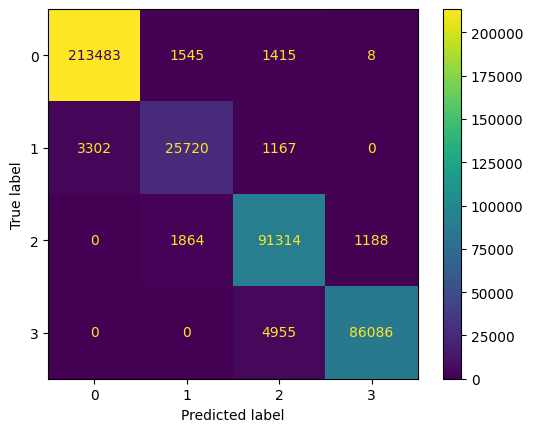

In [21]:

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot()
plt.show()

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    216451
           1       0.88      0.85      0.87     30189
           2       0.92      0.97      0.95     94366
           3       0.99      0.95      0.97     91041

    accuracy                           0.96    432047
   macro avg       0.94      0.94      0.94    432047
weighted avg       0.96      0.96      0.96    432047



In [24]:
import joblib
filename='segmentation_model_skullstrip2.sav'
joblib.dump(model,filename)

['segmentation_model_skullstrip2.sav']